# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.utils import resample
from sklearn import neighbors, svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import \
    train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import \
    recall_score, precision_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, plot_precision_recall_curve, plot_confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline

The Skin Segmentation dataset is constructed over B, G, R color space. Skin and Nonskin dataset is generated using skin textures from face images of diversity of age, gender, and race people.

The skin dataset is collected by randomly sampling B,G,R values from face images of various age groups (young, middle, and old), race groups (white, black, and asian), and genders obtained from FERET database and PAL database. 

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Assignment/classification/datasets/Skin_NonSkin.txt',
                      delimiter='\t', header=None, names=['B', 'G', 'R', 'skin-nonskin'])

# Dataset explore

In [ ]:
df.head()

,B,G,R,skin-nonskin
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


In [ ]:
print("Skin sample: {}".format(len(df[df['skin-nonskin'] == 1])))
print("Non Skin sample: {}".format(len(df[df['skin-nonskin'] == 2])))

Skin sample: 50859
Non Skin sample: 194198


Total learning sample size is 245057; out of which 50859 is the skin samples and 194198 is non-skin samples. So, y = 1 is skin and y = 2 is non-skin

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245057 entries, 0 to 245056
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   B             245057 non-null  int64
 1   G             245057 non-null  int64
 2   R             245057 non-null  int64
 3   skin-nonskin  245057 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB


In [ ]:
df.describe()

,B,G,R,skin-nonskin
count,245057.000000,245057.000000,245057.000000,245057.000000
mean,125.065446,132.507327,123.177151,1.792461
std,62.255653,59.941197,72.562165,0.405546
min,0.000000,0.000000,0.000000,1.000000
25%,68.000000,87.000000,70.000000,2.000000
50%,139.000000,153.000000,128.000000,2.000000
75%,176.000000,177.000000,164.000000,2.000000
max,255.000000,255.000000,255.000000,2.000000


We can see that our target variable is binary, but that it's made of 1s and 2s.

The best practice is to have our binary variable be represented as 0s and 1s. 

So, let's change our Skin or No-Skin variable to 0s and 1s.

In [ ]:
df['skin-nonskin'] = df['skin-nonskin'] - 1

In [ ]:
print("Skin sample: {}".format(len(df[df['skin-nonskin'] == 0])))
print("Non Skin sample: {}".format(len(df[df['skin-nonskin'] == 1])))

Skin sample: 50859
Non Skin sample: 194198


# Skin and non-skin visualization

In [ ]:
width = 5
height = 4
skin_array = np.zeros([height, width, 3], dtype=np.uint8)
nonskin_array = np.zeros([height, width, 3], dtype=np.uint8)

## Skin

B, G, R values: [56, 105, 167]


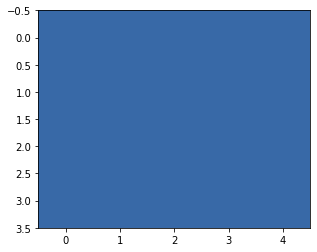

B, G, R values: [57, 117, 183]


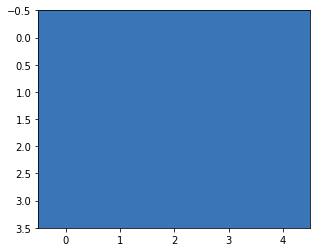

B, G, R values: [181, 197, 244]


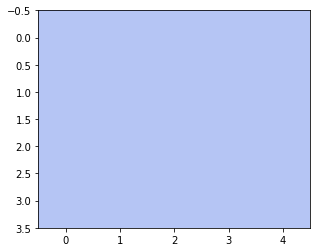

B, G, R values: [201, 211, 251]


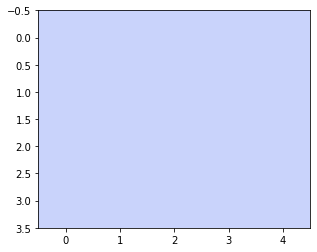

B, G, R values: [120, 150, 209]


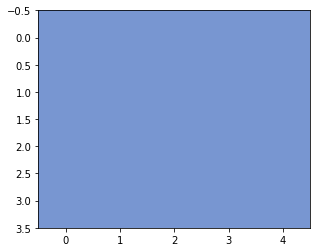

In [ ]:
skin_array_indexes = df[df['skin-nonskin'] == 0].index.values
random_skins = np.random.choice(skin_array_indexes, 5)

for i in random_skins:
    skin_array[:, :] = list(df.iloc[i].values[:-1])
    print(f"B, G, R values: {list(df.iloc[i].values[:-1])}")
    plt.imshow(skin_array)
    plt.show()

## Non Skin

B, G, R values: [158, 159, 115]


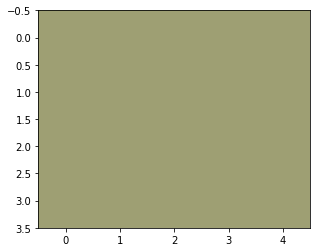

B, G, R values: [0, 182, 0]


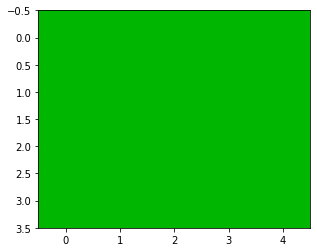

B, G, R values: [72, 72, 26]


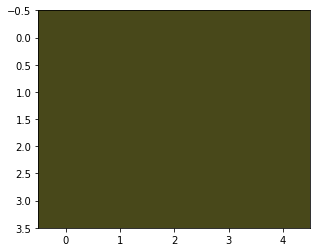

B, G, R values: [124, 191, 124]


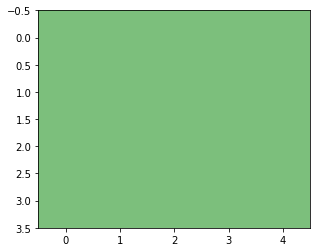

B, G, R values: [172, 140, 99]


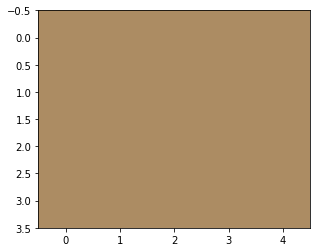

In [ ]:
nonskin_array_indexes = df[df['skin-nonskin'] == 1].index.values
random_nonskins = np.random.choice(nonskin_array_indexes, 5)

for i in random_nonskins:
    nonskin_array[:, :] = list(df.iloc[i].values[:-1])
    print(f"B, G, R values: {list(df.iloc[i].values[:-1])}")
    plt.imshow(nonskin_array)
    plt.show()

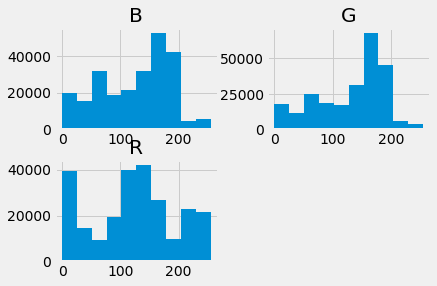

In [ ]:
plt.style.use('fivethirtyeight')
df[['B', 'G', 'R']].hist()
plt.show()

Features are relatively normally distributed. While we don't need our features to be normally distributed to run logistic regression, it does make our data nicer to work with and is good to keep in mind when interpreting our results.

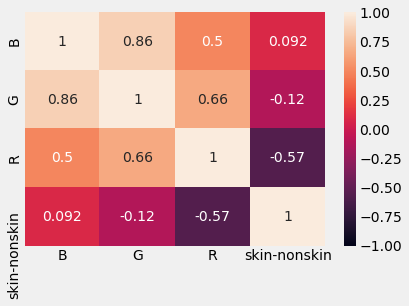

In [ ]:
_ = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

# Data split

In [ ]:
X = df.drop('skin-nonskin', axis=1).values
y = df['skin-nonskin'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)


# KNN

- Basic idea: Predict the label of a data point by
    > - Looking at the 'k' closest labeled data points
    > - Taking a majority vote
    
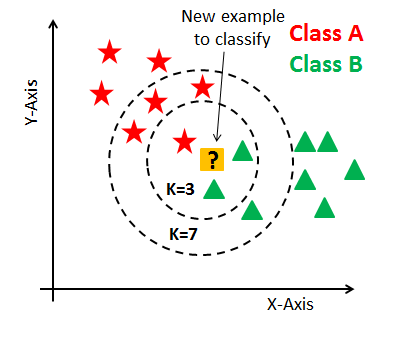

Image taken from: https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.datacamp.com%2Fcommunity%2Ftutorials%2Fk-nearest-neighbor-classification-scikit-learn&psig=AOvVaw3Ecv83sqiUTkSng63Mgq43&ust=1603634436436000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCOCU0_axzewCFQAAAAAdAAAAABAD

In [ ]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

In [ ]:
X.shape

(245057, 3)

In [ ]:
y.shape

(245057,)

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

147034
98023
147034
98023


## KNN Evaluation

In [ ]:
# No. of correct prediction / Total no of data points
print("Accuracy {:.4f}".format(knn.score(X_test, y_test)))
knn_accuracy = knn.score(X_test, y_test)

Accuracy 0.9993


In [ ]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 26)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

### Model complexity curve

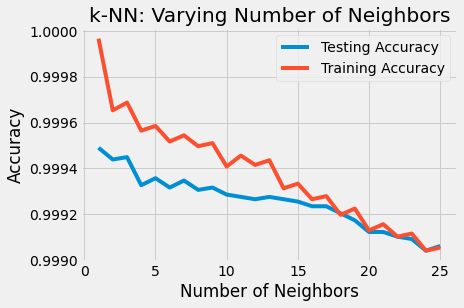

In [ ]:
# Generate plot
plt.style.use('fivethirtyeight')
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

From the above graph, we can conclude that when K is small i.e. K=1, Training Accuracy is High but Test Accuracy is Low which means the model is over-fitting ( High Variance or High Model Complexity). When the value of K is large i.e. K=50, Training Accuracy is Low as well as Test Accuracy is Low which means the model is under-fitting ( High Bias or Low Model Complexity ).

So Hyperparameter tuning is necessary i.e. to select the best value of K in KNN algorithm for which the model has Low Bias and Low Variance and results in a good model with high out of sample accuracy.

We can use GridSearchCV or RandomSearchCv to find the best value of hyper parameter K.

### Hyperparameter tuning with GridSearchCV

In [ ]:
param_grid = {'n_neighbors': np.arange(1, 26)}
knn_grid = KNeighborsClassifier()
knn_cv = GridSearchCV(knn_grid, param_grid, cv=5)
knn_cv.fit(X, y)
print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 25}
0.9925323859170332


We retrieve the hyperparameters that perform the best along with the mean cross-validation score over that fold

### Classification report & Confusion Matrix KNN

In [ ]:
print(f"Classification report\n\n {classification_report(y_test, y_pred_knn)}\n")
print(f"Confusion matrix\n\n {confusion_matrix(y_test, y_pred_knn)}\n")

Classification report

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20200
           1       1.00      1.00      1.00     77823

    accuracy                           1.00     98023
   macro avg       1.00      1.00      1.00     98023
weighted avg       1.00      1.00      1.00     98023


Confusion matrix

 [[20199     1]
 [   66 77757]]



### Confusion Matrix Seaborn

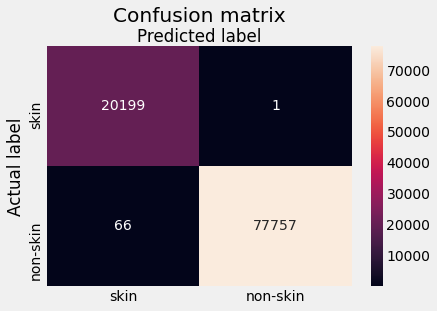

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
class_names = df['skin-nonskin'].unique()
fig, ax = plt.subplots()
tick_marks = list(class_names)
plt.xticks(tick_marks, list(class_names))
plt.yticks(tick_marks, list(class_names))

#heatmap
sns.heatmap(pd.DataFrame(cm_knn), xticklabels=['skin', 'non-skin'], yticklabels=['skin', 'non-skin'], annot=True, fmt='g')
ax.xaxis.set_label_position('top')
_ = plt.tight_layout()
_ = plt.title('Confusion matrix', y=1.1)
_ = plt.ylabel('Actual label')
_ = plt.xlabel('Predicted label')

rows - predicted

columns - Actual

TP = These are skin and they were correctly identified by the algorithm

TN = These are non-skin and they were correctly identified by the algo

FN = These are Skin but algo said non-skin

FP = These are non skin but algo said skin

There were $20199$ TP, skins that were correctly classified

There were $77757$ TN, non-skins that were correctly classified

However, the algorithm misclassified 66 instances that were skin but said those are non-skin(FN)

and the algorithm misclassified $1$ instance that were non-skin but said skin(FP)

The numbers along the diagonal tell us how many times the samples were correctly classified

The numbers not on the diagonal are samples the messed up


# Logistic Regression

Logistic regression predicts whether something is True or False, instead of predicting something continuous like size.

Als, instead of fitting a line to the data, logistic regression fits an "S" shaped "logistic function"

The curve goes from 0 to 1.

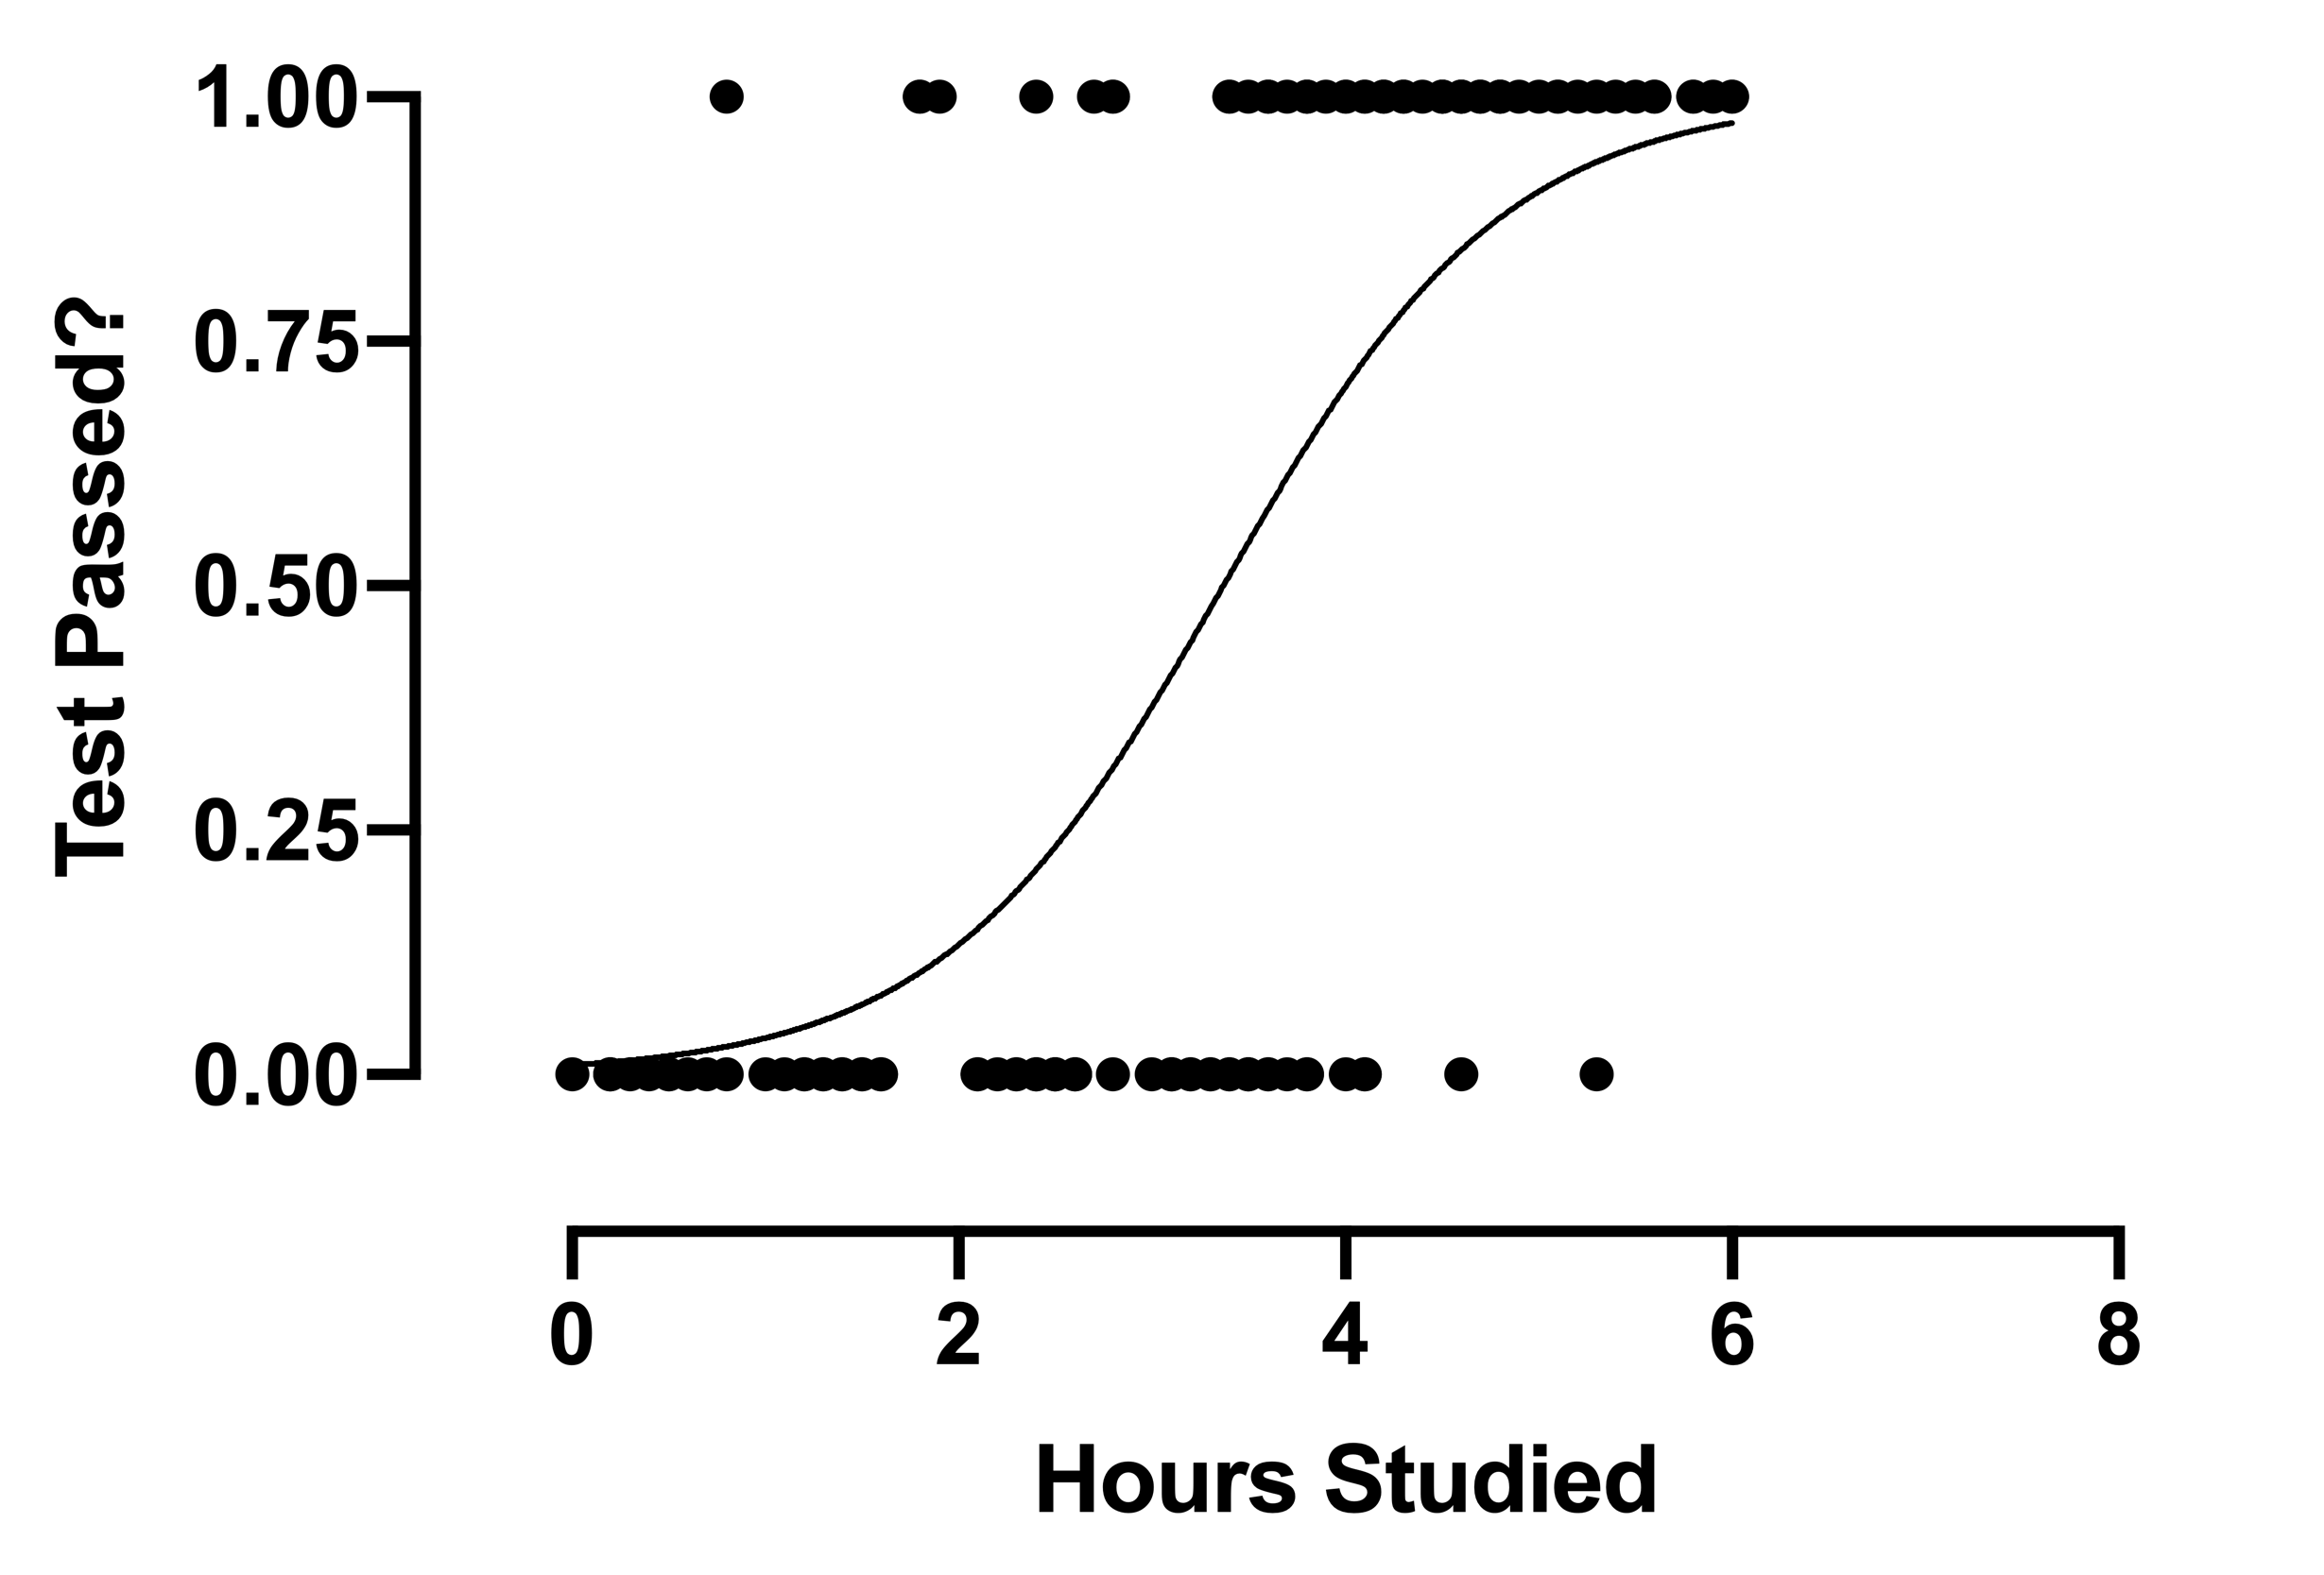

Image taken from: https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.graphpad.com%2Fguides%2Fprism%2F8%2Fcurve-fitting%2Freg_simple_logistic_and_linear_difference.htm&psig=AOvVaw0TpXKHDZdhJyYobDY4Fs9a&ust=1603634497553000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCJCqq5uyzewCFQAAAAAdAAAAABAJ

In [ ]:
# Create the classifier: logreg
logreg = LogisticRegression(random_state=42)

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred_logreg
y_pred_logreg = logreg.predict(X_test)

## Logistic regression evaluation

### Accuracy

In [ ]:
print("Accuracy: {:.4f}".format(logreg.score(X_test, y_test)))
logreg_accuracy = logreg.score(X_test, y_test)

Accuracy: 0.9193


### Classification report & Confusion Matrix

In [ ]:
# Compute and print the confusion matrix and classification report
print(f"Classification report\n\n {classification_report(y_test, y_pred_logreg)}\n")
print(f"Confusion matrix\n\n {confusion_matrix(y_test, y_pred_logreg)}\n")

Classification report

               precision    recall  f1-score   support

           0       0.79      0.83      0.81     20200
           1       0.95      0.94      0.95     77823

    accuracy                           0.92     98023
   macro avg       0.87      0.88      0.88     98023
weighted avg       0.92      0.92      0.92     98023


Confusion matrix

 [[16674  3526]
 [ 4385 73438]]



$$Precision = \frac{TP}{TP + FP}$$

Our model has a precision of 0.79—in other words, when it predicts a sample is skin, it is correct around 79% of the time.

$$Recall = \frac{TP}{TP + FN}$$

Our model has a recall of 0.83—in other words, it correctly identifies 83% of all skins.

### Confusion Matrix

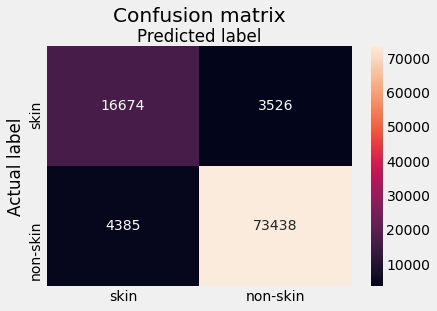

In [ ]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
class_names = df['skin-nonskin'].unique()
fig, ax = plt.subplots()
tick_marks = list(class_names)
plt.xticks(tick_marks, list(class_names))
plt.yticks(tick_marks, list(class_names))

#heatmap
sns.heatmap(pd.DataFrame(cm_logreg), xticklabels=['skin', 'non-skin'], yticklabels=['skin', 'non-skin'], annot=True, fmt='g')
ax.xaxis.set_label_position('top')
_ = plt.tight_layout()
_ = plt.title('Confusion matrix', y=1.1)
_ = plt.ylabel('Actual label')
_ = plt.xlabel('Predicted label')

Logistic regression was worse than the K-Nearest Neighbors at predicting skins with($16674$ vs $20199$) and worse at predicting non-skins ($73438$ vs $77757$)

### ROC Curve

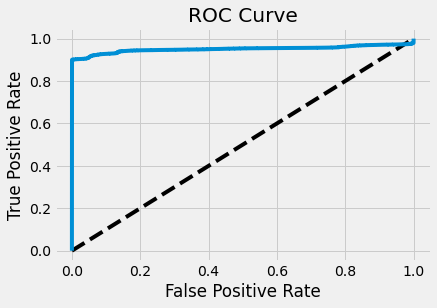

In [ ]:
# Compute predicted probabilities: y_pred_prob
# compute the predicted probabilities of the labels of the test set
y_pred_prob_logreg = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_pred_prob_logreg)

# Plot ROC curve
plt.style.use('fivethirtyeight')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logreg, tpr_logreg)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print(f"ROC Curve (AUC={roc_auc_score(y_test, y_pred_prob_logreg):.4f})")

ROC Curve (AUC=0.9509)


We can set the classification threshold between $0$ and $1$ to create many confusion matrices. The $ROC$ graph summarizes all of the confusion matrices that each threshold produced.
 
$ROC$ graphs are drawn using $TPR$ and $FPR$ to summarize confusion matrices.
 
The $y-axis$ shows the $TPR$, which is the same thing as $Sensitiviy$
 
The $TPR$ tells you what proportion of skin samples were correctly classified
 
The $x-axis$ shows the $FPR$, which is the same thing as $1 - Specificity$
 
The $FPR$ tells you the proportion of non-skin samples that were incorrectly classified and are FP
 
A point at 1,1 means that even though we correctly classified all of the skin samples, we incorrectly classified all of the samples that were non-skins
 
The black line shows where the TPR = FPR.
 
Any point on this line means that the proportion of correctly classified skin samples is the same as the proportion of incorrectly classified samples that are non-skins
 
since the new point (0.8, 0.95) is to the left of the line we know that the proportion of correctly classified samples that were skins(TP) is greater than the proportion of the samples that were incorrectly classified as skin(FP)
 
if we think about (04, 0.95) is even further to the left of the line, showing that the new threshold further decreases the proportion of the samples that were incorrectly classified as skin(FP)
 
The threshold represented by the new point (0, 0.9) correctly classified 90% of the skin samples and 100% of the samples that were non skin. In other word this threshold resulted in no FP


In [ ]:
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 10-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 10-fold cross-validation: [0.8735338  0.89739912 0.99475252 0.98525374 0.99488753 0.99443872
 0.93787519 0.94160657 0.93628024 0.90343305]


In [ ]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X, y)

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1e-05}
Best score is 0.9094867788204976


It looks like a 'C' of $1e-05$ results in the best performance.

### Hold-out

In [ ]:
# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_se

Tuned Logistic Regression Parameter: {'C': 0.0007196856730011522, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.9187874959854222


# Model selection

## ROC Curve for KNN

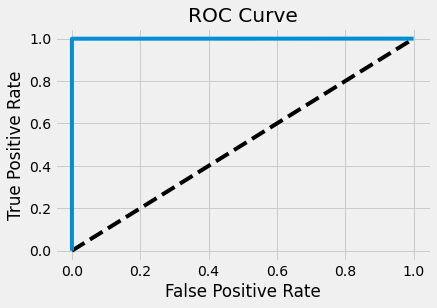

In [ ]:
# Compute predicted probabilities: y_pred_prob
# compute the predicted probabilities of the labels of the test set
y_pred_prob_knn = knn.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)

# Plot ROC curve
plt.style.use('fivethirtyeight')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print(f"ROC Curve (AUC={roc_auc_score(y_test, y_pred_prob_knn):.4f})")

ROC Curve (AUC=0.9998)


## ROC Curve for Logistic regression

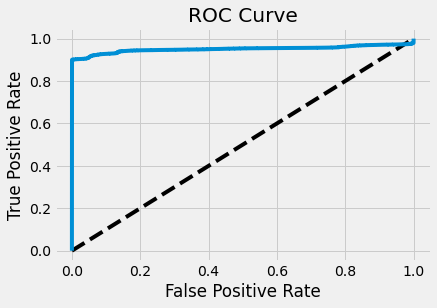

In [ ]:
# Compute predicted probabilities: y_pred_prob
# compute the predicted probabilities of the labels of the test set
y_pred_prob_logreg = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_pred_prob_logreg)

# Plot ROC curve
plt.style.use('fivethirtyeight')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logreg, tpr_logreg)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print(f"ROC Curve (AUC={roc_auc_score(y_test, y_pred_prob_logreg):.4f})")

ROC Curve (AUC=0.9509)


The AUC makes it easy to compare one ROC curve to another.

The AUC for KNN curve is greater than the AUC for Logistic regression ROC curve, suggesting that the KNN curve is better. So, we should use KNN.

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_knn).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("KNN")
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)

KNN
Specificity:  0.999950495049505
Sensitivity:  0.9991519216684014


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_logreg).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Logistic regression")
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)

Logistic regression
Specificity:  0.8254455445544554
Sensitivity:  0.9436541896354548


Sensitivity tells us what % of samples that are skins were correctly identified

$$Sensitivity = \frac{TP}{TP + FN}$$

Specifcity tells us what % of samples that are non-skins were correctly identified

$$Specifcity = \frac{TN}{TN + FP}$$

# SVM

- SVM constructs a hyperplane in multidimensional space
- SVM generates optimal hyperplane in an iterative manner

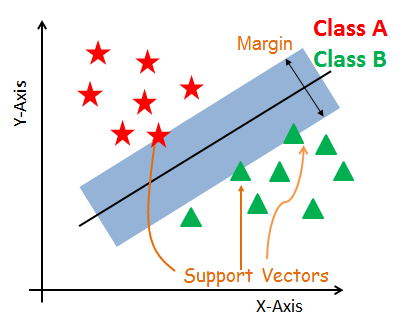

In [ ]:
# Create a svm classifier
clf_svm_full = svm.SVC()

# Train the model using training sets
clf_svm_full.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

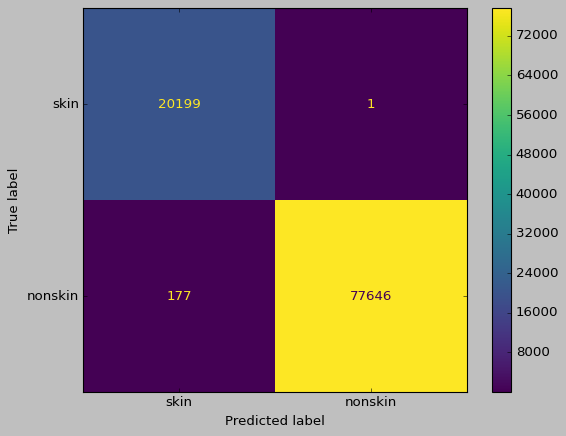

In [ ]:
plt.style.use('classic')
plot_confusion_matrix(
    clf_svm_full,
    X_test,
    y_test,
    values_format='d',
    display_labels=['skin', 'nonskin']
)
plt.show()

In [ ]:
param_grid = [
              {'C': [0.5, 1, 10, 100],
               'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
               'kernel': ['rbf']
               }
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)
optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

In [ ]:
y_pred_clf_svm_full = clf_svm_full.predict(X_test)

In [ ]:
clf_svm_full_accuracy = clf_svm_full.score(X_test, y_test)

In [ ]:
print(clf_svm_full_accuracy)

0.9981840996500821


In [ ]:
print(classification_report(y_test, y_pred_clf_svm_full))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20200
           1       1.00      1.00      1.00     77823

    accuracy                           1.00     98023
   macro avg       1.00      1.00      1.00     98023
weighted avg       1.00      1.00      1.00     98023



In [ ]:
# Create a svm classifier
clf_svm_full_poly = svm.SVC(karnel='poly', degree=8)

# Train the model using training sets
clf_svm_full_poly.fit(X_train, y_train)

In [ ]:
# Create a svm classifier
clf_svm_full_poly = svm.SVC(karnel='linear')

# Train the model using training sets
clf_svm_full_poly.fit(X_train, y_train)

# ANN

A neural network is a machine learning algorithm with training data being the input to the input layer and predicted value the value at the output layer. Each connection from one neuron to another has an associated weight w. Each neuron, except the input layer which just holds the input value, also has an extra weight we call the bias weight b. During feed-forward out input gets transformed by weight multiplications and additions at each layer, the output layer of each neuron can also get transformed by the appication of what's called an activation function.

Learning in neural network consist of tuning the weights or parameters to give desired output. One way of achieving this is by using the famous Gradient descent algorithm and applying weight updates incrementally via a process known as back-propagation.

In [ ]:
n_cols = X.shape[1]

In [ ]:
# Create a Sequential model
model = Sequential()

# Add an input layer and a hidden layer with 10 neurons
model.add(Dense(12, input_shape=(n_cols,), activation="relu"))

# hidden layer with 8 neurons
model.add(Dense(8, activation='relu'))

# Add a 1-neuron output layer
model.add(Dense(1, activation='sigmoid'))

# Summarise your model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
h_callback = model.fit(
    X_train, 
    y_train,
    epochs=50,
    validation_data=(X_test, y_test)
)

Epoch 1/50
4595/4595 [==============================] - 15s 3ms/step - loss: 0.1647 - accuracy: 0.9787 - val_loss: 0.0189 - val_accuracy: 0.9957
Epoch 2/50
4595/4595 [==============================] - 15s 3ms/step - loss: 0.0192 - accuracy: 0.9956 - val_loss: 0.0139 - val_accuracy: 0.9964
Epoch 3/50
4595/4595 [==============================] - 15s 3ms/step - loss: 0.0171 - accuracy: 0.9961 - val_loss: 0.0124 - val_accuracy: 0.9973
Epoch 4/50
4595/4595 [==============================] - 15s 3ms/step - loss: 0.0159 - accuracy: 0.9961 - val_loss: 0.0115 - val_accuracy: 0.9974
Epoch 5/50
4595/4595 [==============================] - 16s 3ms/step - loss: 0.0152 - accuracy: 0.9962 - val_loss: 0.0122 - val_accuracy: 0.9970
Epoch 6/50
4595/4595 [==============================] - 14s 3ms/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.0163 - val_accuracy: 0.9961
Epoch 7/50
4595/4595 [==============================] - 15s 3ms/step - loss: 0.0140 - accuracy: 0.9965 - val_loss: 0.0112 - val_ac

In [ ]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

In [ ]:
def plot_accuracy(acc,val_acc):
  # Plot training & validation accuracy values
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

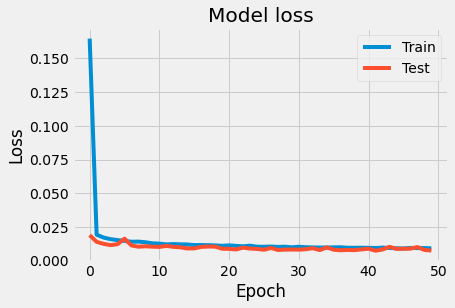

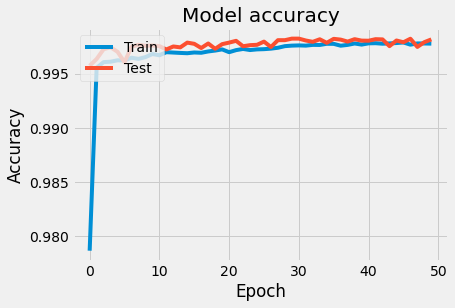

In [ ]:
plt.style.use('fivethirtyeight')
# Plot train vs test loss during training
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(h_callback.history['accuracy'], h_callback.history['val_accuracy'])

In [ ]:
# Create a Sequential model
model1 = Sequential()

# Add an input layer and a hidden layer with 10 neurons
model1.add(Dense(100, input_shape=(n_cols,), activation="relu"))

# hidden layer with 8 neurons
model1.add(Dense(52, activation='relu'))

# Add a 1-neuron output layer
model1.add(Dense(1, activation='sigmoid'))

# Summarise your model
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               400       
_________________________________________________________________
dense_13 (Dense)             (None, 52)                5252      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 53        
Total params: 5,705
Trainable params: 5,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
h_callback1 = model1.fit(
    X_train, 
    y_train,
    epochs=50,
    validation_data=(X_test, y_test)
)

Epoch 1/50
4595/4595 [==============================] - 14s 3ms/step - loss: 9.4352e-08 - accuracy: 0.2380 - val_loss: 9.4643e-08 - val_accuracy: 0.2363
Epoch 2/50
4595/4595 [==============================] - 15s 3ms/step - loss: 9.4352e-08 - accuracy: 0.2380 - val_loss: 9.4643e-08 - val_accuracy: 0.2363
Epoch 3/50
4595/4595 [==============================] - 14s 3ms/step - loss: 9.4352e-08 - accuracy: 0.2380 - val_loss: 9.4643e-08 - val_accuracy: 0.2363
Epoch 4/50
4595/4595 [==============================] - 14s 3ms/step - loss: 9.4352e-08 - accuracy: 0.2380 - val_loss: 9.4643e-08 - val_accuracy: 0.2363
Epoch 5/50
4595/4595 [==============================] - 15s 3ms/step - loss: 9.4352e-08 - accuracy: 0.2380 - val_loss: 9.4643e-08 - val_accuracy: 0.2363
Epoch 6/50
4595/4595 [==============================] - 14s 3ms/step - loss: 9.4352e-08 - accuracy: 0.2380 - val_loss: 9.4643e-08 - val_accuracy: 0.2363
Epoch 7/50
4595/4595 [==============================] - 14s 3ms/step - loss: 9.435

In [ ]:
loss, ann_accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", ann_accuracy)

3064/3064 [==============================] - 5s 2ms/step - loss: 0.0086 - accuracy: 0.9981
Loss:  0.00862167403101921
Accuracy:  0.9980821013450623


In [ ]:
loss, accuracy = model1.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

3064/3064 [==============================] - 5s 2ms/step - loss: 9.4643e-08 - accuracy: 0.2363
Loss:  9.464335448683414e-08
Accuracy:  0.2363220900297165


In [ ]:
predictions_nn = model.predict(X_test)

In [ ]:
predictions_nn_class = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
confusion_matrix(y_test, predictions_nn_class)

array([[20192,     8],
       [  180, 77643]])

In [ ]:
accuracy_list = [knn_accuracy, logreg_accuracy, clf_svm_full_accuracy, ann_accuracy]

In [ ]:
acc_df = pd.DataFrame(accuracy_list, index=["KNN", "Logistic regression", "SVM", "ANN"],
                      columns=['Accuracy'])
acc_df

,Accuracy
KNN,0.999316
Logistic regression,0.919294
SVM,0.998184
ANN,0.998082


# SVM With Downsampled data

Support vector machines are one of the best ml methods when getting the correct answer is higher priority than understanding why you get the correct answer. They work really well with relativly small datasets and they tend to work well 'out of the box'. In other words they don't require much opimization.

In [ ]:
df_skin = df[df['skin-nonskin'] == 0]
df_nonskin = df[df['skin-nonskin'] == 1]

In [ ]:
len(df_skin)

50859

In [ ]:
df_skin_downsampled = resample(
    df_skin,
    replace=False,
    n_samples=6000,
    random_state=42
)
len(df_skin_downsampled)

6000

In [ ]:
df_nonskin_downsampled = resample(
    df_nonskin,
    replace=False,
    n_samples=6000,
    random_state=42
)
len(df_nonskin_downsampled)

6000

In [ ]:
df_skin_downsampled

,B,G,R,skin-nonskin
48220,124,155,224,0
14090,126,167,216,0
46986,116,145,220,0
48596,119,152,221,0
9580,146,184,232,0
...,...,...,...,...
47396,106,149,206,0
28002,128,162,216,0
22816,130,154,214,0
41877,85,121,191,0


In [ ]:
df_downsampled = pd.concat(
    [df_skin_downsampled, df_nonskin_downsampled]
)
len(df_downsampled)

12000

In [ ]:
X_svm = df_downsampled.drop(
    'skin-nonskin',
    axis=1
).copy()
y_svm = df_downsampled['skin-nonskin'].copy()

In [ ]:
X_svm.head()

,B,G,R
48220,124,155,224
14090,126,167,216
46986,116,145,220
48596,119,152,221
9580,146,184,232


In [ ]:
y_svm.head()

48220    0
14090    0
46986    0
48596    0
9580     0
Name: skin-nonskin, dtype: int64

In [ ]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm,
    y_svm,
    test_size=0.4,
    random_state=42
)

In [ ]:
clf_svm = svm.SVC(random_state=42)
clf_svm.fit(X_train_svm, y_train_svm)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

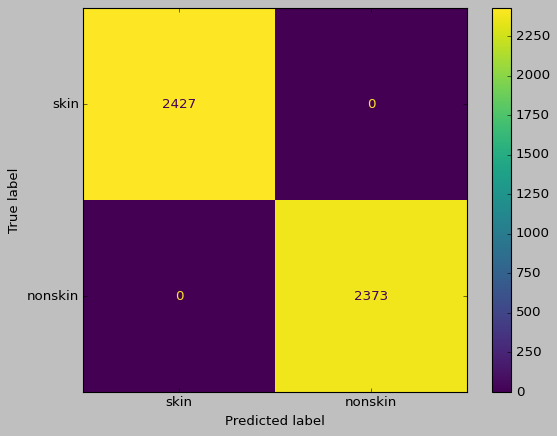

In [ ]:
plt.style.use('classic')
plot_confusion_matrix(
    clf_svm,
    X_test_svm,
    y_test_svm,
    values_format='d',
    display_labels=['skin', 'nonskin']
)
plt.show()

In [ ]:
param_grid = [
              {'C': [0.5, 1, 10, 100],
               'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
               'kernel': ['rbf']
               }
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)
optimal_params.fit(X_train_svm, y_train_svm)
print(optimal_params.best_params_)

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
clf_svm = svm.SVC(random_state=42, C=1, gamma=0.01)
clf_svm.fit(X_train_svm, y_train_svm)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

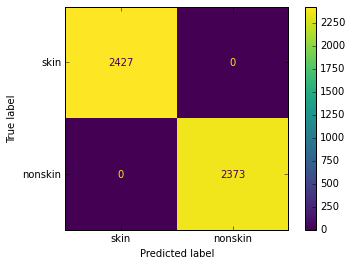

In [ ]:
plot_confusion_matrix(
    clf_svm,
    X_test_svm,
    y_test_svm,
    values_format='d',
    display_labels=['skin', 'nonskin']
)
plt.show()

In [ ]:
# Create a svm classifier
clf_svm_full_lin = svm.SVC(kernel='linear')

# Train the model using training sets
clf_svm_full_lin.fit(X_train_svm, y_train_svm)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
# Create a svm classifier
clf_svm_full_poly = svm.SVC(kernel='poly')

# Train the model using training sets
clf_svm_full_poly.fit(X_train_svm, y_train_svm)

y_pred = clf_svm_full_poly.predict(X_test_svm)

In [ ]:
print(confusion_matrix(y_test_svm,y_pred))
print(classification_report(y_test_svm,y_pred))

[[2425    2]
 [  30 2343]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2427
           1       1.00      0.99      0.99      2373

    accuracy                           0.99      4800
   macro avg       0.99      0.99      0.99      4800
weighted avg       0.99      0.99      0.99      4800

